In [703]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops

def read_img(img_name, img_dir = 'in_dir/', grayscale=False):
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    return img
images_out = 'images_out/' 
def save_img(fname, img_out, out_dir = images_out, grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [704]:
in_dir = 'in_dir/'
img_me = read_img('me_resized.jpg', img_dir=in_dir)
img_george = read_img('george_small.jpg', img_dir=in_dir)

In [705]:
corr_file = in_dir + 'points_fixed.json'
f = open(corr_file)
correspondences = json.load(f)
img1_points = np.array(correspondences['im1Points'])
img2_points = np.array(correspondences['im2Points'])
mean_points = (img1_points + img2_points)/2

In [706]:
def plot_tri_on_img(img, points, fname='', out_dir = images_out):
    tri = Delaunay(points).simplices

    plt.triplot(points[:, 0], points[:,1], tri)
    plt.plot(points[:, 0], points[:,1], 'o')
    plt.imshow(img)
    # plt.axis('off')
    if fname != '':
        plt.savefig(out_dir + fname, bbox_inches='tight')
    
    plt.show()

def get_tri(weighted_pts):
    return Delaunay(weighted_pts)

def weighted_sum(arr1, arr2, weight):
    return arr1 * weight + arr2 * (1-weight)

def get_weighted_tri(img1_pts, img2_pts, warp_frac):
    weighted_pts = weighted_sum(img1_pts, img2_pts, warp_frac)
    return get_tri(weighted_pts)

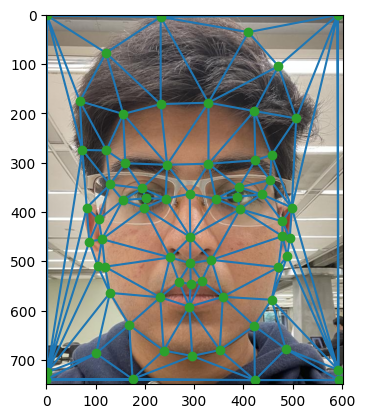

In [670]:
part_1_out = images_out + 'part_1/'
plot_tri_on_img(
    img_me, img1_points,
    fname='me_triangles.jpg',
    out_dir=part_1_out
)

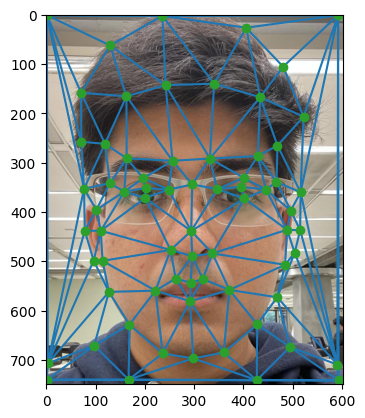

In [671]:
part_1_out = images_out + 'part_1/'
plot_tri_on_img(
    img_me, 
    mean_points,
)

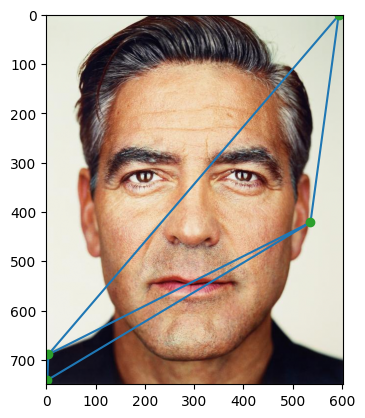

In [702]:
plot_tri_on_img(
    img_george,
    img2_points[-5:-1],
    fname='george_triangles.jpg',
    out_dir=part_1_out
)

In [697]:
img2_points[-5:]

array([[  2, 741],
       [536, 421],
       [593,   1],
       [  4, 689],
       [589, 699]])

In [673]:
def compute_transform(points):
    a, b, c = points
    trans = np.eye(3)
    trans[:2,0] = c - a
    trans[:2,1] = b - a
    trans[:2,2] = a
    # print(points, trans)
    return trans

def compute_warp_src_dst(src_points, dst_points, tris):
    num_tri = len(tris)
    transforms = np.zeros((num_tri, 3, 3))
    for (i, tri) in enumerate(tris):
        tri_idx = mean_tri.simplices[i]
        dst_tri_points = list(map(lambda x: dst_points[x], tri_idx))
        src_tri_points = list(map(lambda x: src_points[x], tri_idx))
        
        g_1 = compute_transform(src_tri_points)
        g_1_inv = np.linalg.inv(g_1)
        g_2 = compute_transform(dst_tri_points)
        transforms[i] = g_2 @ g_1_inv
    return transforms

mean_tri = get_weighted_tri(img1_points, img2_points, 0.5)
mean_to_img1 = compute_warp_src_dst(mean_points, img1_points, mean_tri.simplices)

In [674]:
def plot_tri(img, weighted_pts, tri):
    tri_points = np.array(list(map(lambda x: weighted_pts[x], tri)))
    cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)
    blank = np.zeros((img.shape))
    blank[rr, cc] = img_me[rr, cc]
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.imshow(blank, cmap='gray')

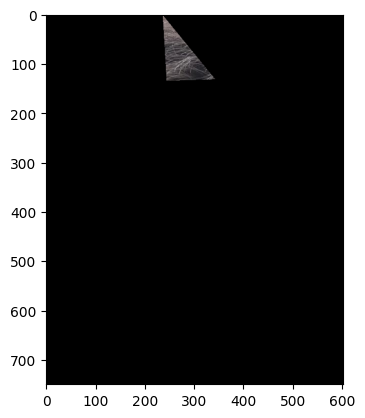

In [675]:
warp_frac = 0.4
weight_tri = get_weighted_tri(img1_points, img2_points, warp_frac)
weighted_pts = weighted_sum(img1_points, img2_points, warp_frac)
weight_to_img1 = compute_warp_src_dst(mean_points, img1_points, weight_tri.simplices)
plot_tri(img_me, weighted_pts, weight_tri.simplices[6])

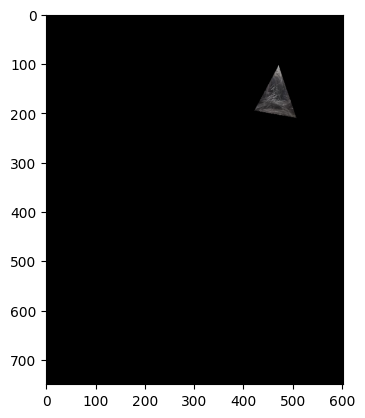

In [676]:
plot_tri(img_me, img1_points, get_tri(img1_points).simplices[15])

In [435]:
rr, cc = None, None
for (i, tri) in enumerate(mean_tri.simplices):
    tri_points = np.array(list(map(lambda x: mean_points[x], tri)))
    cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)
    if i == 15:
        break

In [436]:
print(img_me.shape)

(750, 602, 3)


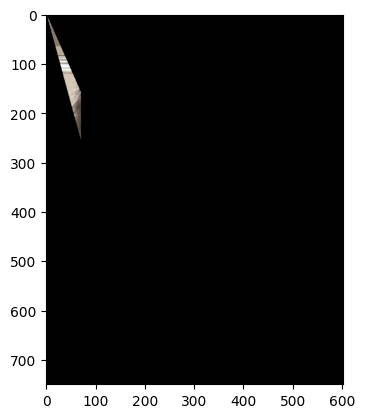

In [437]:
blank = np.zeros((img_me.shape))
blank[rr, cc] = img_me[rr, cc]
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.imshow(blank, cmap='gray')

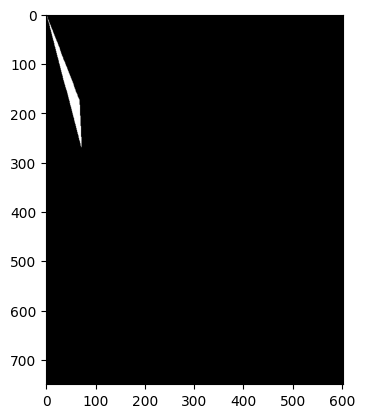

In [438]:
src_tri_coords = np.array([cc, rr, np.ones_like(rr)])
new =  mean_to_img1[15] @ src_tri_coords

c_n, r_n = new[0], new[1]
c_i, r_i = c_n.astype(int), r_n.astype(int)
blank = np.zeros(img_me.shape[:2])
blank[r_i, c_i] = 1
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(blank, cmap='gray')

In [439]:
print(c_i, r_i)

[ 1  2  2 ... 71 71 71] [  3   4   6 ... 267 268 269]


[ 1.97476779  2.02069773  2.97250055 ... 71.84151247 71.8874424
 71.93337234] [  3.73593944   4.72964967   6.968734   ... 267.28921963 268.28292986
 269.27664009]
[  3   4   6 ... 251 252 253] [ 2  2  3 ... 70 70 70]


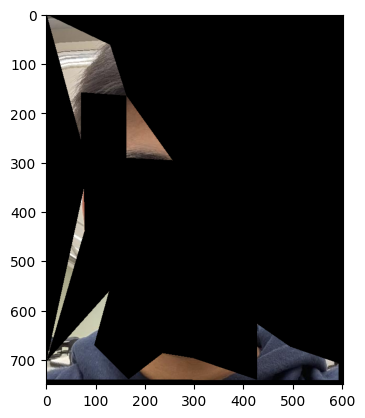

In [455]:
X, Y = np.mgrid[:img_me.shape[0], :img_me.shape[1]]
points = np.dstack((X.ravel(), Y.ravel())).squeeze()
blank = np.zeros((img_me.shape))
flat_img = einops.rearrange(img_me, ('h w c -> (h w) c'))

for (i, tri) in enumerate(mean_tri.simplices):
    if i> 15: continue
    tri_points = np.array(list(map(lambda x: mean_points[x], tri)))
    cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)

    src_tri_coords = np.array([cc, rr, np.ones_like(rr)])
    new =  mean_to_img1[i] @ src_tri_coords
    c_n, r_n = new[0], new[1]
    if i==15:
        print(c_n, r_n)
        print(rr, cc)
    tri_interp = scipy.interpolate.griddata(
        points, flat_img, (r_n, c_n), method='nearest'
    )
    blank[rr, cc] = tri_interp
plt.imshow(blank)

In [428]:
X, Y = np.mgrid[:img_me.shape[0], :img_me.shape[1]]
points = np.dstack((X.ravel(), Y.ravel())).squeeze()
flat_img = einops.rearrange(img_me, ('h w c -> (h w) c'))
print(flat_img.shape, points.shape)

(451500, 3) (451500, 2)


In [429]:
tri_interp = scipy.interpolate.griddata(
    points, flat_img, (c_n, r_n), method='nearest'
)
blank[rr, cc] = tri_interp

In [430]:
tri_interp.shape

(3321, 3)

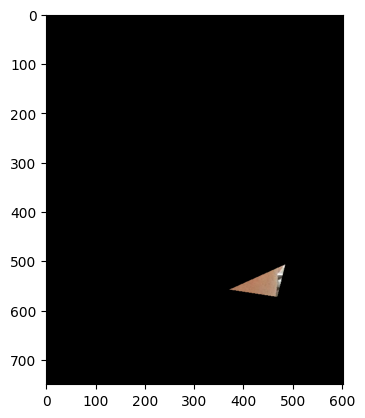

In [431]:
blank = np.zeros((img_me.shape))
blank[rr, cc] = tri_interp
plt.gca().set_aspect('equal', adjustable='box')
plt.imshow(blank)

In [707]:
def get_inv_mapped_color(img, mean_tri, mean_to_img_transforms, weighted_shape_pts):
    # Flatten img to use for interpolation
    X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
    points = np.dstack((X.ravel(), Y.ravel())).squeeze()
    flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
    new_image = np.zeros_like(img)
    color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)

    for (i, tri) in enumerate(mean_tri.simplices):
        # Gets all points within mean triangle
        tri_points = np.array(list(map(lambda x: weighted_shape_pts[x], tri)))
        cc, rr = ski.draw.polygon(tri_points[:,0], tri_points[:,1], shape=None)
        
        src_tri_coords = np.array([cc, rr, np.ones_like(rr)])   # Create homogeneous coordinates
        new =  mean_to_img_transforms[i] @ src_tri_coords     # Apply transformation to get tri in original image
        c_n, r_n = new[0], new[1]
        
        # Interpolate at to get the colors of the points when inv mapped
        # tri_interp = scipy.interpolate.griddata(
        #     points, flat_img, (r_n, c_n), method='nearest'
        # )
        tri_interp = color_interp((r_n, c_n))
        new_image[rr, cc] = tri_interp
    return new_image

# Computes the morphed img, weighting img1 by warp_frac and img2 by (1-warp_frac)
def compute_morphed_img(img1, img2, triangulation, img1_points, img2_points, warp_frac, dissolve_frac=None):
    if dissolve_frac == None: dissolve_frac = warp_frac
    weighted_shape_pts = weighted_sum(img1_points, img2_points, warp_frac)

    transforms_to_img1 = compute_warp_src_dst(weighted_shape_pts, img1_points, triangulation.simplices)
    colors_from_img1 = get_inv_mapped_color(img1, triangulation, transforms_to_img1, weighted_shape_pts) 
    # print('finished img1')
    transforms_to_img2 = compute_warp_src_dst(weighted_shape_pts, img2_points, triangulation.simplices)
    colors_from_img2 = get_inv_mapped_color(img2, triangulation, transforms_to_img2, weighted_shape_pts) 
    return weighted_sum(colors_from_img1, colors_from_img2, dissolve_frac)

def compute_morph_seq(img1, img2, img1_points, img2_points, num_img):
    img_seq = []
    mean_tri = get_weighted_tri(img1_points, img2_points, 0.5)
    for t in range(0,num_img):
        warp_frac = t/num_img
        img_seq.append(
            compute_morphed_img(img1, img2, mean_tri, img1_points, img2_points, warp_frac, dissolve_frac=None)
        )
    return img_seq

In [708]:
seq = compute_morph_seq(img_me, img_george, img1_points, img2_points, 45)

helloooo 9
helloooo 10
helloooo 11
helloooo 12
helloooo 13
helloooo 14
helloooo 15
helloooo 16
helloooo 17
helloooo 18
helloooo 19
helloooo 20
helloooo 21
helloooo 22


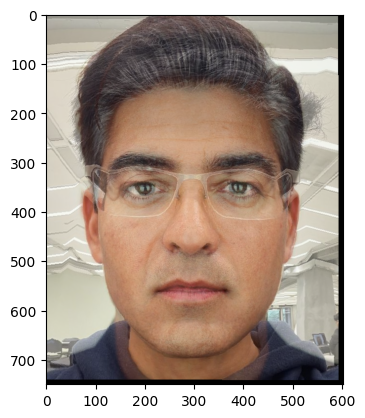

In [627]:
plt.imshow(seq[5])

In [518]:
transforms_to_img1 = compute_warp_src_dst(mean_points, img1_points, mean_tri.simplices)
colors_from_me = get_inv_mapped_color(img_me, mean_tri, transforms_to_img1, mean_points)

In [ ]:
print(mean_tri.simplices)

In [519]:
transforms_to_img2 = compute_warp_src_dst(mean_points, img2_points, mean_tri.simplices)
colors_from_george = get_inv_mapped_color(img_george, mean_tri, transforms_to_img2, mean_points)

In [531]:
morph = (colors_from_me + colors_from_george) / 2
morph = weighted_sum(colors_from_me, colors_from_george, 0.5)

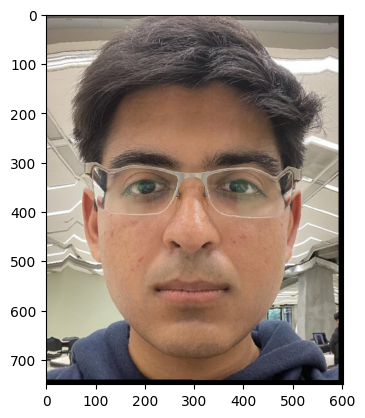

In [587]:
warp_frac = 0.5
morph1, t1, t2 = compute_morphed_img(
    img_me, img_george, 
    img1_points, img2_points, 
    warp_frac, dissolve_frac=1
)
plt.imshow(morph1)

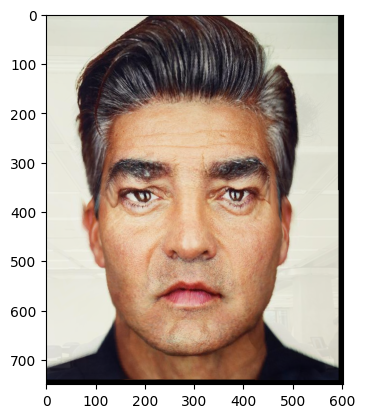

In [642]:
morph1 = compute_morphed_img(
    img_me, img_george, 
    mean_tri,
    img1_points, img2_points,
    warp_frac=0.99, 
    dissolve_frac=0.1
)
plt.imshow(morph1)

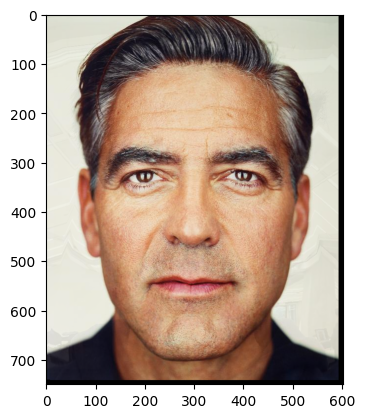

In [643]:
morph1 = compute_morphed_img(
    img_me, img_george, 
    mean_tri,
    img1_points, img2_points,
    warp_frac=0.01, 
    dissolve_frac=0.1
)
plt.imshow(morph1)